<a href="https://colab.research.google.com/github/lqiang67/generative-models-on-toys/blob/main/vae_2D_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

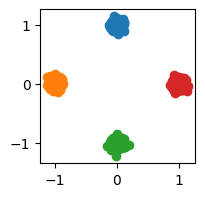

In [99]:
#@title Generate Toy Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal, kl_divergence
from collections import namedtuple

# generating circular gmm toy dataset.
import torch
import matplotlib.pyplot as plt
import numpy as np
DataInfo = namedtuple('data_info', ['centers', 'cluster_idx'])
def sample_circular_gmm(batch_size, num_modes=4, radius=1.0, std=0.05):
    angles = torch.linspace(0, 2 * torch.pi, num_modes+1)[:-1] + torch.pi/2
    centers = torch.stack([radius * torch.cos(angles), radius * torch.sin(angles)], dim=1)
    cluster_idx = torch.randint(0, num_modes, (batch_size,))
    selected_centers = centers[cluster_idx]
    batch_data = selected_centers + std * torch.randn(batch_size, 2)

    data_info = DataInfo(centers=centers, cluster_idx=cluster_idx)
    return batch_data, data_info

# Visualize the data
data_points, data_info = sample_circular_gmm(1000, num_modes=4)

plt.figure(figsize=(2, 2))
for i in range(len(data_info.centers)):
    idx = (data_info.cluster_idx == i)
    plt.scatter(data_points[idx, 0], data_points[idx, 1])


In [75]:
#@title: the VAE Model
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal, kl_divergence


# a general MLP which can use customed linear layers and activation functions.
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation=nn.ReLU, linear_layer=nn.Linear):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        self.linear_layer = linear_layer
        for i in range(len(layer_sizes) - 1):
            self.layers.append(self.linear_layer(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # No activation after the last layer
                self.layers.append(self.activation())

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x


# Define the VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, hidden_sizes=[128,128],
                 vae_beta = 1.0,
                 logvar_decoder = torch.tensor([0.0])):
        super(VAE, self).__init__()
        # Encoder
        self.latent_dim = latent_dim
        self.hidden_sizes = hidden_sizes
        self.input_dim = input_dim
        self.vae_beta = vae_beta
        self.logvar_decoder = logvar_decoder

        self.encoder = MLP(layer_sizes=[input_dim] + hidden_sizes + [2*latent_dim])
        self.decoder = MLP(layer_sizes=[latent_dim] + hidden_sizes + [2*input_dim])

    def encode(self, x):
        h = self.encoder(x)
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        return mu, logvar


    def decode(self, z):
        x = self.decoder(z)
        mu = x[:, :self.input_dim]
        if self.logvar_decoder is not None:
            # set logvar to be a fixed constant (typical setting)
            logvar = self.logvar_decoder*torch.ones_like(mu)
        else:
            # trainable logvar.
            logvar = x[:, self.input_dim:]
        return mu, logvar

    @staticmethod
    def neg_gaussian_log_likelihood(x, mu, logvar):
        return 0.5 * (logvar + torch.log(2 * torch.tensor([torch.pi])) + (x - mu) ** 2 / torch.exp(logvar))

    @staticmethod
    def sample_gaussian(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return mu + eps * std

    @staticmethod
    def gaussian_kl_divergence(mu1, logvar1, mu2, logvar2):
        # Calculate the KL divergence between two Gaussians
        #kl_div = torch.log(sigma2 / sigma1) + (sigma1 ** 2 + (mu1 - mu2) ** 2) / (2 * sigma2 ** 2) - 0.5
        kl_div = (logvar2 - logvar1)/2.0 + (torch.exp(logvar1) + (mu1 - mu2) ** 2) / (2 * torch.exp(logvar2)) - 0.5
        return kl_div

    # generating sample form VAE
    def generation(self, num_samples):
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim)
            mu, logvar = self.decode(z)
            x_gen = self.sample_gaussian(mu, logvar)
        return x_gen

    def forward(self, x):
        mu_z_given_x, logvar_z_given_x = self.encode(x)
        z = self.sample_gaussian(mu_z_given_x, logvar_z_given_x)
        mu_x_given_z, logvar_x_given_z = self.decode(z)

        #Loss = E[-logp(x|z) + KL(q(z|x) || p(z))]
        kl_div = self.gaussian_kl_divergence(mu_z_given_x, logvar_z_given_x, 0*mu_z_given_x, 0*logvar_z_given_x)
        neg_logpxz = self.neg_gaussian_log_likelihood(x, mu_x_given_z, logvar_x_given_z)

        prior_loss = torch.mean(kl_div)
        reconstruct_loss = torch.mean(neg_logpxz)

        return  reconstruct_loss, prior_loss


In [76]:
#@title Plot script
def show_results(vae, data_points, data_info):

    x = torch.tensor(data_points) # data
    mu_z_x, logvar_z_x = vae.encode(x) # encoding
    z = vae.sample_gaussian(mu_z_x, logvar_z_x) # sample latent

    mu_x_z, logvar_x_z = vae.decode(z) # decoding
    x_rec = mu_x_z # reconstruct

    z_gen = torch.randn_like(z) # sample normal
    mu3, logvar3 = vae.decode(z_gen) # decoding
    x_gen = mu3

    Nsubplts = 10; ctsubplts = 1
    plt.figure(figsize=(3*Nsubplts, 3))

    plt.subplot(1,Nsubplts, ctsubplts); ctsubplts+=1
    plt.plot(loss_curve)
    plt.title('total loss')

    plt.subplot(1,Nsubplts, ctsubplts); ctsubplts+=1
    plt.plot(rec_loss_curve)
    plt.title('reconstruction loss')

    plt.subplot(1,Nsubplts, ctsubplts); ctsubplts+=1
    plt.plot(prior_loss_curve)
    plt.title('prior loss')

    plt.subplot(1,Nsubplts, ctsubplts); ctsubplts+=1
    for i in range(len(data_info.centers)):
        idx = data_info.cluster_idx == i
        plt.scatter(mu_z_x.detach()[idx, 0], mu_z_x.detach()[idx, 1], alpha=0.5)
    plt.title('E[z|x]')

    plt.subplot(1,Nsubplts, ctsubplts); ctsubplts+=1
    std = torch.exp(0.5 * logvar_z_x)
    for i in range(len(data_info.centers)):
        idx = data_info.cluster_idx == i
        plt.scatter(std.detach()[idx, 0], std.detach()[idx, 1], alpha=0.5)
    plt.title('std(z|x)')

    plt.subplot(1,Nsubplts, ctsubplts); ctsubplts+=1
    for i in range(len(data_info.centers)):
        idx = data_info.cluster_idx == i
        plt.scatter(z.detach()[idx, 0], z.detach()[idx, 1], alpha=0.5)
    plt.title('sample of z|x')

    plt.subplot(1,Nsubplts, ctsubplts); ctsubplts+=1
    for i in range(len(data_info.centers)):
        idx = data_info.cluster_idx == i
        plt.scatter(x.detach()[idx, 0], x.detach()[idx, 1], alpha=0.5)
        plt.scatter(x_rec.detach()[idx, 0], x_rec.detach()[idx, 1], alpha=0.5)
    plt.title('reconstructed x')

    plt.subplot(1,Nsubplts, ctsubplts); ctsubplts+=1
    for i in range(len(data_info.centers)):
        idx = data_info.cluster_idx == i
        plt.scatter(x.detach()[idx, 0], x.detach()[idx, 1],  alpha=0.5)
    plt.plot(x_gen.detach()[:, 0], x_gen.detach()[:, 1], '.y', alpha=0.5)
    plt.title('sampled x')


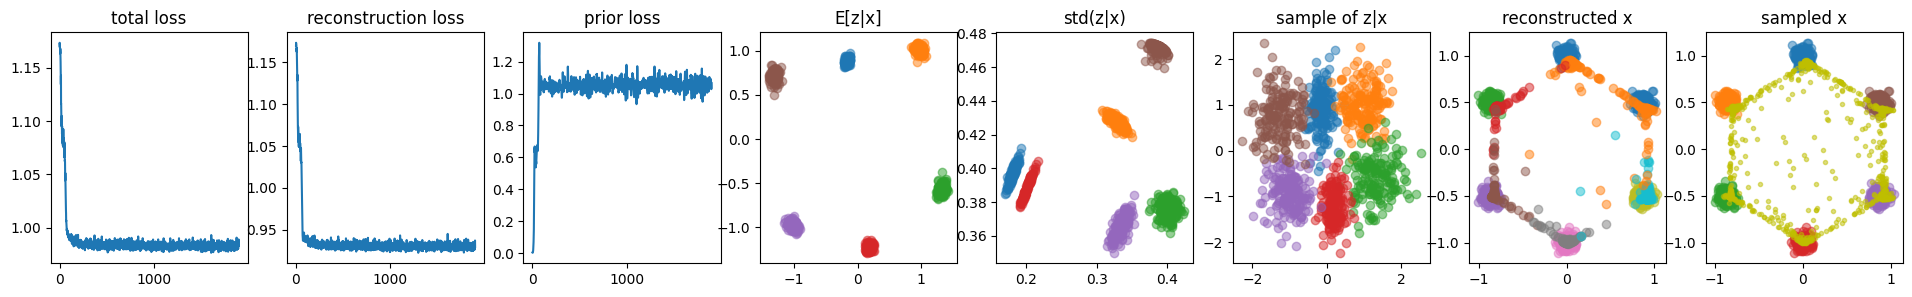

100%|██████████| 2000/2000 [00:59<00:00, 33.37it/s]


In [87]:
#@title  Training
# changing beta balances the two loss terms, but it is very difficult to trade off
from tqdm import tqdm
from IPython.display import clear_output

data_points, data_info = sample_circular_gmm(1000, num_modes=6)
vae = VAE(input_dim=2, latent_dim=2, hidden_sizes = [128,128,128])#, logvar_decoder=None)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
vae_beta = 0.05

# Training loop
vae.train()
loss_curve = []
rec_loss_curve = []
prior_loss_curve = []
batch_size = 256
for steps in tqdm(range(2000)):
  batch_idx = torch.randperm(len(data_points))[:batch_size]
  x = torch.tensor(data_points[batch_idx])
  optimizer.zero_grad()
  rec_loss, prior_loss = vae(x)
  loss = rec_loss + vae_beta * prior_loss
  loss.backward()
  optimizer.step()

  rec_loss_curve.append(rec_loss.item())
  prior_loss_curve.append(prior_loss.item())
  loss_curve.append(loss.item())

  if steps % 100==0:
      clear_output(wait=True)
      show_results(vae, data_points, data_info)
      plt.show()